# William Fallas

# williamfallas@gmail.com

# Transport delays


In [1]:
import  pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, StringType, StructField, StructType,FloatType,DecimalType,BooleanType
from pyspark.sql.functions import isnan, when, count, col

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()

%matplotlib inline



spark = SparkSession \
    .builder \
    .appName("Proyecto_WilliamFallas") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

Traer los datos procesados de posgress

In [2]:

db_url="jdbc:postgresql://host.docker.internal:5433/postgres"
# traer datos no escalados de base de datos
dfSAAS = spark \
    .read \
    .format("jdbc") \
    .option("url", db_url) \
    .option("user", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .option("password", "testPassword") \
    .option("dbtable", "finaldf") \
    .load()


example_df = dfSAAS.select(col("OrgState"),col("DestState"),col("ServiceLevel"),col("EventSeverity"),col("ConRetraso"))
example_df.show()

print("Cantidad Total de filas:")
print(dfSAAS.count())


+--------+---------+------------+-------------+----------+
|OrgState|DestState|ServiceLevel|EventSeverity|ConRetraso|
+--------+---------+------------+-------------+----------+
|      AL|       GA|    STANDARD|         91.0|         0|
|      AL|       IN|    STANDARD|         91.0|         0|
|      AL|       OH|    STANDARD|         91.0|         1|
|      AL|       NE|    STANDARD|         91.0|         0|
|      AL|       VA|    STANDARD|         91.0|         1|
|      AL|       IA|    STANDARD|         91.0|         1|
|      AL|       IN|    STANDARD|         91.0|         1|
|      AL|       SC|    STANDARD|         91.0|         1|
|      AL|       TX|    STANDARD|         91.0|         0|
|      AL|       TX|    STANDARD|        120.0|         1|
|      AL|       MS|    STANDARD|        120.0|         1|
|      AL|       FL|    STANDARD|         29.0|         0|
|      AL|       NC|    STANDARD|         29.0|         1|
|      AL|       TX|    STANDARD|         29.0|         

## Exploratorio de Datos

In [4]:
dfSAAS.columns

['OrgState',
 'DestState',
 'ShipmentDirection',
 'ServiceLevel',
 'Priorityid',
 'TotalFreightCost',
 'MaxFreightClass',
 'Total_Pieces',
 'Total_Pallets',
 'Total_Weight',
 'CarrierCode',
 'Has_Hazmat',
 'Has_LiftGate',
 'is_Holiday',
 'PickUpDay',
 'PickUpMonth',
 'PickupDate',
 'EventSeverity',
 'ConRetraso']

### Descripción de las columnas

-OrgState: Lugar de origen de la carga, donde se recogen los bienes.

-DestState: Destino de la carga, o entrega de bienes.

-ShipmentDirection: Inbound,Outbound,third Party, Indica si la carga es entrada de materia prima(inbound) o entrega de productos acabados(outbound), Third Party, indica si el transporte lo terminada por un tercero.

-PriorityID: Tipo de prioridad que tiene la carga: Normal o Hot.

-TotalFreightCost: Monto total del transporte, suma del total del monto de la carga.

-MaxFreightClass: Las clases de carga son una medida que permite precios estándar en todos los transportistas y empresas de carga LTL, la clase generalmente varía de 60 a 400 y se basa en tipos específicos de productos. Por ejemplo, los refrigeradores pertenecen a la clase 92.5, mientras que los gabinetes se clasifican como clase de carga 110.

-Total_Pieces: Total de piezas que se van transportar.

-Total_Pallets: cantidad de tarimas necesarias para la cargas.

-Total_Weight: Peso total de la carga.

-CarrierCode: Identificador global del transportista, se puede obtener el nombre del transportista haciendo join con la tabla Carrier, mediante el campo carrierId.

-Has_Hazmat: Indica si se transportara materiales peligrosos.

-Has_LiftGate:Indica si la carga debe entregarse en puerta y si debe utilizar equipo especial de carga  y descarga.

-PickUpDay: Calculado, Dia de la semana que se recogió la carga 

-PickUpMonth: Calculado, Mes en que solicito la carga.

-PickupDate: Columna utilizada solo para visualizaciones de tiempo, se eliminara.

-EventSeverity:Campo numerico calculado,  con la combinación de las columnas: Type y severity, dando mayor peso a los eventos mas importes, por ejemplo: Snow=3, Rain=2, Fog=1, Light=1, Moderate=2, Severe=3


-ConRetraso: campo binario que indica si la carga se atrasó o no.


In [4]:
pd_SAAS = dfSAAS.toPandas()
pd_SAAS['PickupDate']= pd.to_datetime(pd_SAAS['PickupDate']) 

In [5]:
pd_SAAS.set_index(pd.to_datetime(pd_SAAS['PickupDate']),inplace=True)
pd_SAAS.index = pd.to_datetime(pd_SAAS.index)

### Distribución de los atrasos en carga 2017-2019

#### Comportamiento de los atrasos de las cargas en el tiempo

<AxesSubplot:xlabel='PickupDate'>

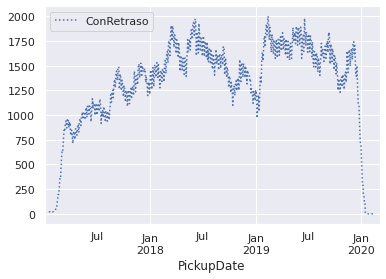

In [6]:

ds = pd_SAAS[["ConRetraso"]]

daily = ds.resample('D').sum()

daily.rolling(30,center=True).sum().plot(style=[':','--','-'])

Existe un incremento importante de atrasos después del 2018, este se debe a que incremento también el número de clientes usuarios del sistema y por tanto el volumen de cargas

In [7]:
df = ds.groupby(ds.index).sum()

/usr/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

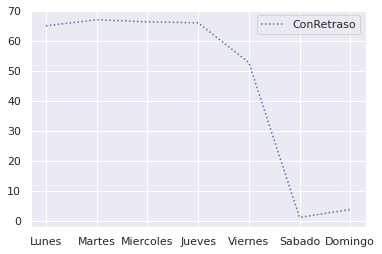

In [8]:
by_weekDay = df.groupby(df.index.dayofweek).mean()
by_weekDay.index=["Lunes","Martes","Miercoles","Jueves","Viernes","Sabado","Domingo"]
by_weekDay.plot(style=[':','--','-'])


Atrasos promedios desde días lunes a jueves es muy similar, el promedio empieza a caer apartir de viernes


/usr/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


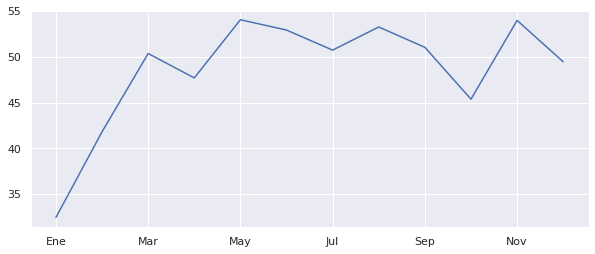

In [9]:
by_Month = df.groupby(df.index.month).mean()

by_Month.index=["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"]
ax = by_Month.plot(legend=False,figsize=(10,4))
#ax.set_xticklabels("by_Month.index")

lines = ax.get_lines() 


Se notan picos de atrasos en los meses de junio y noviembre, según estudios de expertos en logística, una semana después de los grande feriados es común que se presenten atrasos en entregas de cargas

In [10]:
resample = df.resample("M")
DsCargasPorMes = resample.mean()
DsCargasPorMes['year'] = [DsCargasPorMes.index[i].year for i in range(len(DsCargasPorMes))]
DsCargasPorMes['month'] = [DsCargasPorMes.index[i].month for i in range(len(DsCargasPorMes))]
DsCargasPorMes['day'] = [DsCargasPorMes.index[i].day for i in range(len(DsCargasPorMes))]
DsCargasPorMes['dayofweek'] = [DsCargasPorMes.index[i].dayofweek for i in range(len(DsCargasPorMes))]

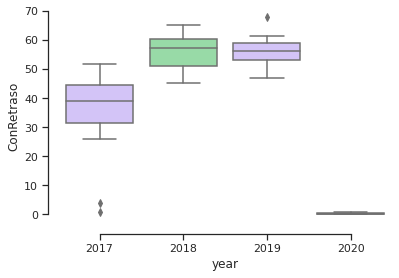

In [11]:
sns.set(style="ticks", palette="pastel")

sns.boxplot(x="year", y="ConRetraso",
             palette=["m", "g"],
            data=DsCargasPorMes)
sns.despine(offset=10, trim=True)

En el año 2016 se nota una importante menor cantidad de atrasos, esto se debe al menor volumen de cargas, se incrementa la cantidad de clientes usuarios del sistema después del año 2017.

Se procede analizar el comportamiento  de los atrasos después del año 2016

In [12]:
Series=DsCargasPorMes[(DsCargasPorMes.index.year<=2020)]

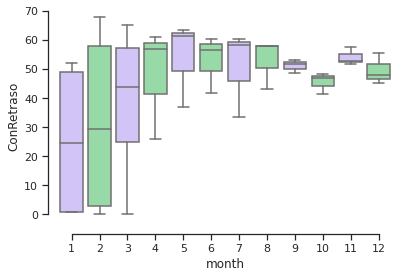

In [13]:

sns.set(style="ticks", palette="pastel")

b = sns.boxplot(x="month", y="ConRetraso",
             palette=["m", "g"],
            data=Series)
sns.despine(offset=10, trim=True)

En enero y febrero la demanda de cargas baja considerablemente, de ahí que el promedio de retrasos esta entre los 20 y 30, alcanzando algunos días inclusive los cero retrasos.

### Análisis de variables numéricas

In [14]:

import seaborn as sns
import matplotlib.pyplot as plt

def AnalisisColumna(columna,df):
    
    
    f, axes = plt.subplots(1,2,figsize=(14,4))

    sns.distplot(df[columna], ax = axes[0])
    axes[0].set_xlabel(columna, fontsize=14)
    axes[0].set_ylabel('cantidad', fontsize=14)
    axes[0].yaxis.tick_left()

    sns.violinplot(x = 'ConRetraso', y = columna, data = df, hue = 'ConRetraso',ax = axes[1])
    axes[1].set_xlabel('ConRetraso', fontsize=14)
    axes[1].set_ylabel(columna, fontsize=14)
    axes[1].yaxis.set_label_position("right")
    axes[1].yaxis.tick_right()

    plt.show();


#### Freight Product class

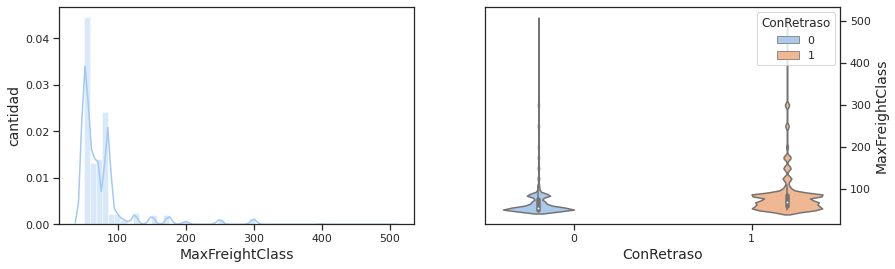

In [15]:
ds = pd_SAAS[["MaxFreightClass","ConRetraso"]]

ds = ds.astype({"MaxFreightClass": float})

AnalisisColumna("MaxFreightClass",ds)

Conforme la clase es mas alta el costo del transporte también sube, Ejemplo:

Class 55		Bricks, cement, mortar, hardwood flooring	35-50 pounds
Class 60		Car accessories & car parts	30-35 pounds
Class 65		Car accessories & car parts, bottled beverages, books in boxes	22.5-30 pounds
Class 70		Car accessories & car parts, food items, automobile engines	15 to 22.5 pounds


Se nota que en clases mayores  se da más frecuencia de atraso de cargas, probablemente las clases mayores son mas complicadas de manipular y transportar.


#### Total_Weight

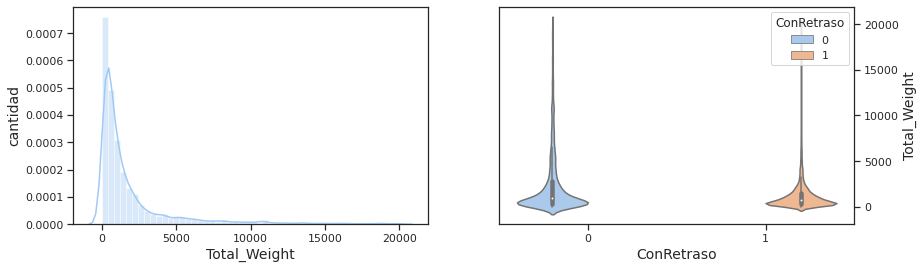

In [16]:

Dsweigh = pd_SAAS[["Total_Weight","ConRetraso"]]

Dsweigh = Dsweigh.astype({"Total_Weight": float})

Dsweigh=Dsweigh[(Dsweigh["Total_Weight"] < 20000)]

AnalisisColumna("Total_Weight",Dsweigh)


Lo pesos menores pueden tender demorarse, ya que implica consolidación de carga por parte del transportista, 
sin embargo, no se nota mayor diferencia entre cargas atrasadas y entregadas a tiempo, es probable que el peso no sea un 
factor para determinar si una carga se atrasa o no

#### TotalFreightCost

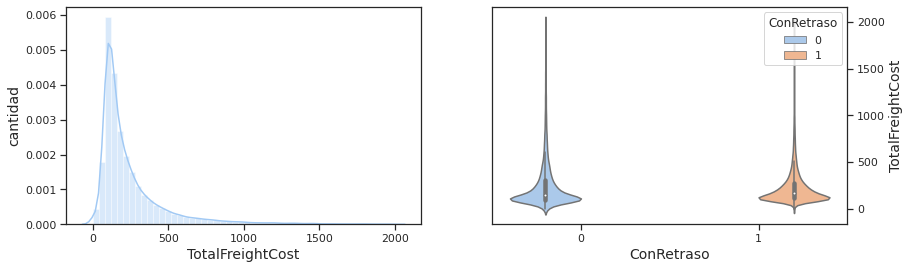

In [17]:
Ds = pd_SAAS[["TotalFreightCost","ConRetraso"]]

Ds = Ds.astype({"TotalFreightCost": float})

Ds=Ds[(Ds["TotalFreightCost"]< 2000)]

AnalisisColumna("TotalFreightCost",Ds)


Las cargas más caras tienden a atrasarse con más frecuencia, si el peso no hace mayor diferencia, probablemente la especialización de las mercancías y su mayor dificultada de manipulación sea el factor mas importante


#### Total_Pieces

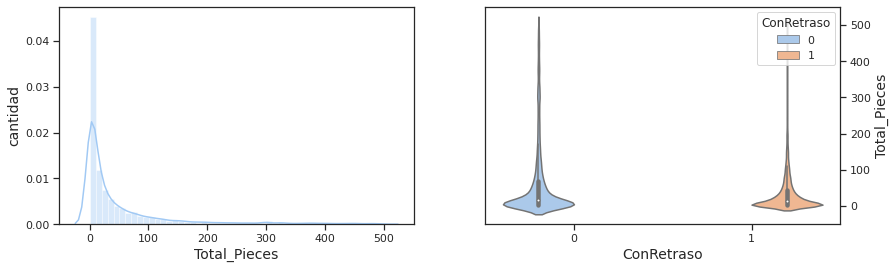

In [18]:
Ds = pd_SAAS[["Total_Pieces","ConRetraso"]]

Ds = Ds.astype({"Total_Pieces": float})

Ds=Ds[(Ds["Total_Pieces"]< 500)]

AnalisisColumna("Total_Pieces",Ds)

No se notan diferencias importantes entre la cantidad de piezas y el atraso de la carga.

#### Total_Pallets

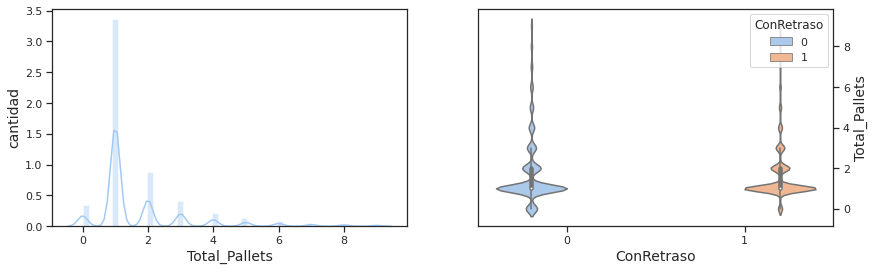

In [19]:
Ds = pd_SAAS[["Total_Pallets","ConRetraso"]]

Ds = Ds.astype({"Total_Pallets": float})

Ds=Ds[(Ds["Total_Pallets"]< 10)]

AnalisisColumna("Total_Pallets",Ds)

No se notan diferencias importantes entre la cantidad de pallets y el atraso de la carga

#### EventSeverity

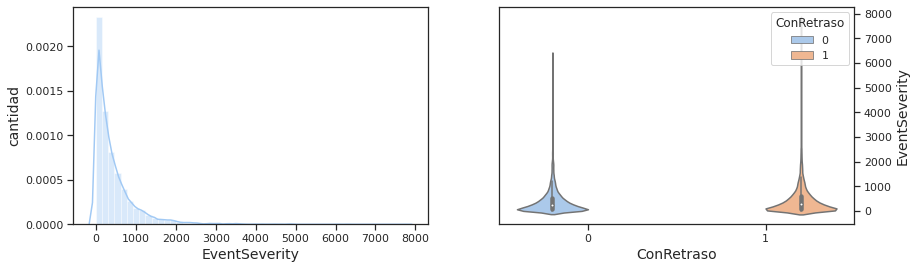

In [20]:
Ds = pd_SAAS[["EventSeverity","ConRetraso"]]

Ds = Ds.astype({"EventSeverity": float})

AnalisisColumna("EventSeverity",Ds)


Al parecer evento severity no aporta mucha información para diferenciar una carga atrasada


#### OrgState

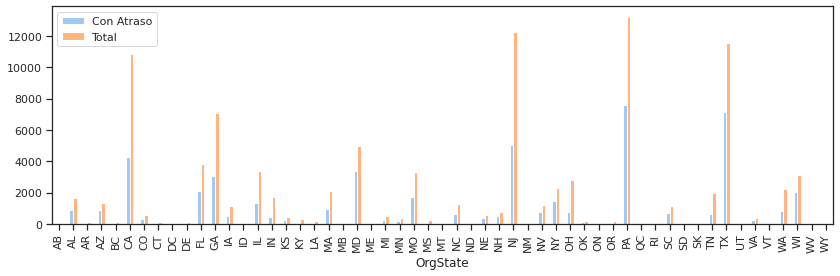

In [21]:
df= pd_SAAS.groupby('OrgState').agg({'ConRetraso':'sum','PickupDate':'count'})
df.rename(columns={'PickupDate': 'total'}, inplace=True)


ax = df.plot(kind='bar', legend=False,figsize=(14,4))
lines = ax.get_lines() 


ax.legend(["Con Atraso","Total"])

#### DestState

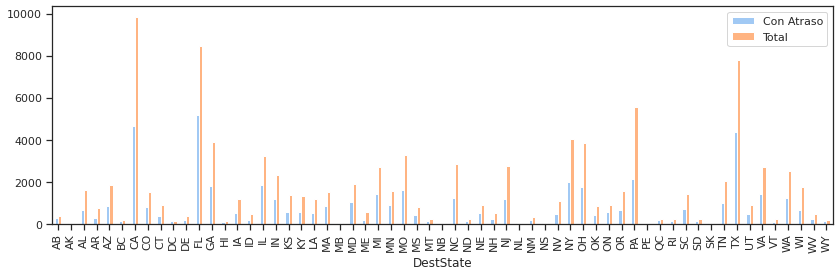

In [22]:
df= pd_SAAS.groupby('DestState').agg({'ConRetraso':'sum','PickupDate':'count'})
df.rename(columns={'PickupDate': 'total'}, inplace=True)


ax = df.plot(kind='bar', legend=False,figsize=(14,4))
lines = ax.get_lines() 


ax.legend(["Con Atraso","Total"])

Origen y destino si aportan información importante en cuanto al atraso, se notan mayores atrasos en Florida, California y Texas.

#### ServiceLevel

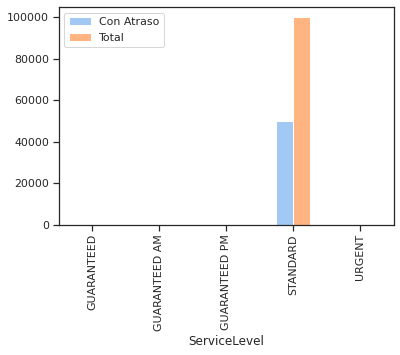

In [23]:
df= pd_SAAS.groupby('ServiceLevel').agg({'ConRetraso':'sum','PickupDate':'count'})
df.rename(columns={'PickupDate': 'total'}, inplace=True)


ax = df.plot(kind='bar', legend=False)
lines = ax.get_lines() 


ax.legend(["Con Atraso","Total"])

#### ShipmentDirection

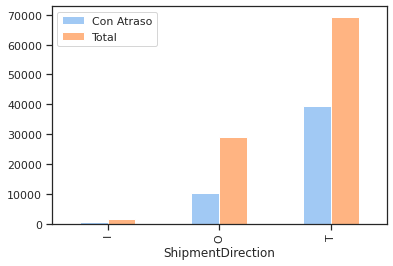

In [24]:
df= pd_SAAS.groupby('ShipmentDirection').agg({'ConRetraso':'sum','PickupDate':'count'})
df.rename(columns={'PickupDate': 'total'}, inplace=True)


ax = df.plot(kind='bar', legend=False)
lines = ax.get_lines() 


ax.legend(["Con Atraso","Total"])

Es esperable que el shipment direction =”third party”  presente mas atrasos, ya que en este tipo de movimiento de mercancías participa mas de un transportista, el transporte final es hecho por una tercera parte

#### Has_Hazmat

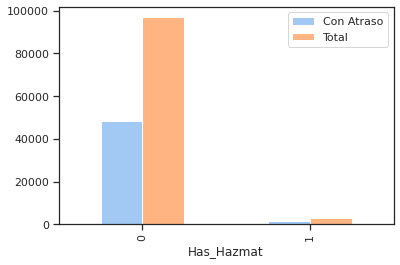

In [25]:
df= pd_SAAS.groupby('Has_Hazmat').agg({'ConRetraso':'sum','PickupDate':'count'})
df.rename(columns={'PickupDate': 'total'}, inplace=True)


ax = df.plot(kind='bar', legend=False)
lines = ax.get_lines() 


ax.legend(["Con Atraso","Total"])


Es más probable que una carga Hazmat(Hazardous material) se atrase ya que estas tienen mas regulaciones gubernamentales para el tránsito en carreteras 


#### Has_LiftGate

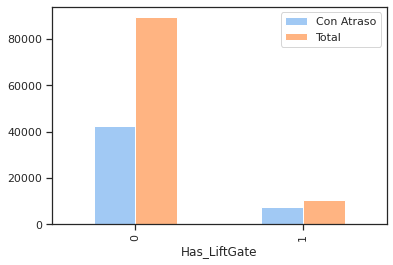

In [26]:
df= pd_SAAS.groupby('Has_LiftGate').agg({'ConRetraso':'sum','PickupDate':'count'})
df.rename(columns={'PickupDate': 'total'}, inplace=True)


ax = df.plot(kind='bar', legend=False)
lines = ax.get_lines() 


ax.legend(["Con Atraso","Total"])

Cuando una carga tiene el accesorio LiftGate tiende a retrasarse más frecuentemente, ya que implica una manipulación mas complicada de carga, descarga y uso de equipo especializado que muchas veces no esta disponible

#### CarrierCode

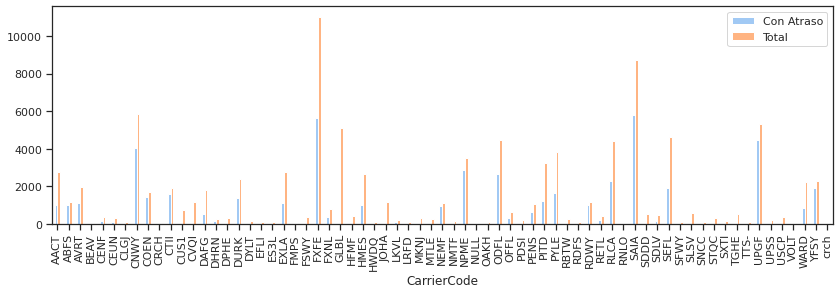

In [27]:
df= pd_SAAS.groupby('CarrierCode').agg({'ConRetraso':'sum','PickupDate':'count'})
df.rename(columns={'PickupDate': 'total'}, inplace=True)


ax = df.plot(kind='bar', legend=False,figsize=(14,4))
lines = ax.get_lines() 


ax.legend(["Con Atraso","Total"])


Los transportistas SAIA y UPGF tiene un porcentaje importante de retrasos comparado con el volumen de cargas asignadas.


#### Matriz de correlación Pearson

<AxesSubplot:>

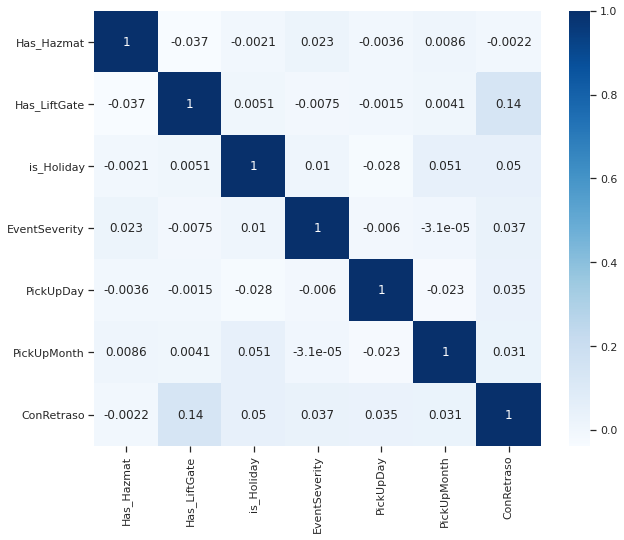

In [42]:
ds = pd_SAAS[["TotalFreightCost","MaxFreightClass","Total_Pieces","Total_Pallets",
                   "Total_Weight","Has_Hazmat","Has_LiftGate","is_Holiday",'EventSeverity',
                   "PickUpDay","PickUpMonth","ConRetraso"]]


corrMatriz = ds.corr()
plt.subplots(figsize=(10,8))
sns.heatmap(corrMatriz, xticklabels=corrMatriz.columns, yticklabels=corrMatriz.columns, annot=True,cmap="Blues")


La matriz de correlación Pearson indica que:

-LiftGate es una característica que tiende a atrasar las cargas

-El mes y la severidad del evento meteorológico aportan cierta correlación con el atraso de las cargas 

-Las otras columnas aportan poca información para distinguir las cargas atrasadas.


# Modelo 1

## Random Forest

In [3]:

from pyspark.ml.feature import VectorAssembler

db_url="jdbc:postgresql://host.docker.internal:5433/postgres"
# traer datos de posgress
df = spark \
    .read \
    .format("jdbc") \
    .option("url", db_url) \
    .option("user", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .option("password", "testPassword") \
    .option("dbtable", "finaldf") \
    .load()


df = df.withColumn("MaxFreightClass", col("MaxFreightClass").cast("Integer"))
df = df.withColumn("Total_Weight", col("Total_Weight").cast("double"))

df = df.drop("PickupDate")

df.schema

StructType(List(StructField(OrgState,StringType,true),StructField(DestState,StringType,true),StructField(ShipmentDirection,StringType,true),StructField(ServiceLevel,StringType,true),StructField(Priorityid,IntegerType,true),StructField(TotalFreightCost,DecimalType(10,0),true),StructField(MaxFreightClass,IntegerType,true),StructField(Total_Pieces,DecimalType(10,0),true),StructField(Total_Pallets,DecimalType(10,0),true),StructField(Total_Weight,DoubleType,true),StructField(CarrierCode,StringType,true),StructField(Has_Hazmat,IntegerType,true),StructField(Has_LiftGate,IntegerType,true),StructField(is_Holiday,IntegerType,true),StructField(PickUpDay,IntegerType,true),StructField(PickUpMonth,IntegerType,true),StructField(EventSeverity,DoubleType,true),StructField(ConRetraso,IntegerType,true)))

In [4]:
df.count()

100000

Para entrenar el modelo se utilizaron alrededor de 50 mil registros, la ejecución tomo mas de 3 horas, para propositos de pruebas se utilizará solo una muestra de un 0.01% del total de datos, con los datos completos el modelo no converge, el Docker da problemas de memoria.

In [5]:
df=df.sample(withReplacement=False, fraction=0.01)
df.count()

992

In [11]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

categoricalColumns = [item[0] for item in df.dtypes if item[1].startswith('string') ]

#define a list of stages in your pipeline. The string indexer will be one stage
stages = []

#iterate through all categorical values
for categoricalCol in categoricalColumns:
    #create a string indexer for those categorical values and assign a new name including the word 'Index'
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')

    #append the string Indexer to our list of stages
    stages += [stringIndexer]

#Create the pipeline. Assign the satges list to the pipeline key word stages
pipeline = Pipeline(stages = stages)
#fit the pipeline to our dataframe
pipelineModel = pipeline.fit(df)
#transform the dataframe
df= pipelineModel.transform(df)
df = df.drop('OrgState', 'DestState', 'ShipmentDirection', 'ServiceLevel', 'CarrierCode')

df = df.select(col("Priorityid"),col("TotalFreightCost"),col("MaxFreightClass"),\
               col("Total_Pieces"),col("Total_Pallets"),col("Total_Weight"),col("Has_Hazmat"),\
               col("Has_LiftGate"),col("is_Holiday"),col("PickUpDay"),col("PickUpMonth"),col("EventSeverity"),
              col("OrgStateIndex").alias("OrgState"),col("DestStateIndex").alias("DestState"),
             col("ShipmentDirectionIndex").alias("ShipmentDirection"),  
            col("ServiceLevelIndex").alias("ServiceLevel"),col("CarrierCodeIndex").alias("CarrierCode"),col("ConRetraso"))

In [12]:
assembler = VectorAssembler(
    inputCols=['Priorityid',
             'TotalFreightCost',
             'MaxFreightClass',
             'Total_Pieces',
             'Total_Pallets',
             'Total_Weight',
             'Has_Hazmat',
             'Has_LiftGate',
             'is_Holiday',
             'PickUpDay',
             'PickUpMonth',
             'EventSeverity',
             'OrgState',
             'DestState',
             'ShipmentDirection',
             'ServiceLevel',
             'CarrierCode'],
    outputCol='features')

vector_df = assembler.setHandleInvalid("skip").transform(df)
vector_df = vector_df.select(['features', 'ConRetraso'])
vector_df.count()


24615

Dividir el Dataset en trainning y test.

In [13]:
train_df, test_df = vector_df.randomSplit([0.7, 0.3], seed = 2018)
train_df = train_df.select(col("ConRetraso").alias("label"), col("features").alias("features"))
test_df = test_df.select(col("ConRetraso").alias("label"), col("features").alias("features"))
print("Training Dataset Count: " + str(train_df.count()))
print("Test Dataset Count: " + str(test_df.count()))

Training Dataset Count: 17283
Test Dataset Count: 7332


In [14]:

from pyspark.ml.classification  import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

# Evaluate model
rfevaluator = BinaryClassificationEvaluator()


rfparamGrid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [5,10,20]) #, 10,20,30]
               .addGrid(rf.maxBins, [70,80,100])#, 20,40,80
               .addGrid(rf.numTrees, [ 20,50,80])#, 50,100
             .build())

# Create 5-fold CrossValidator
rfcv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = rfevaluator,
                      numFolds = 5)

rfcvModel = rfcv.fit(train_df)

#get predictions for test dataframe
rfpredictions = rfcvModel.transform(test_df)

rfpredictions = rfpredictions.withColumn('prediction', rfpredictions['prediction'].cast(IntegerType()))

print(rfcvModel)


CrossValidatorModel_7ace6b166640


El entrenamiento del modelo tarda mas de 20 minutos

In [15]:
rfevaluator.setMetricName("areaUnderROC").evaluate(rfpredictions)

0.8336737947402045

In [16]:
from pyspark.mllib.evaluation import MulticlassMetrics

dfPredictions = rfpredictions.select(['prediction','label']).orderBy('prediction')

dfPredictions = dfPredictions.withColumn("prediction", col("prediction").cast("Float"))
dfPredictions = dfPredictions.withColumn("label", col("label").cast("Float"))

dfPredictions= dfPredictions.orderBy('prediction')


metrics = MulticlassMetrics(dfPredictions.rdd.map(tuple))

# Confusion Matrix
print(metrics.confusionMatrix())

DenseMatrix([[2310., 1377.],
             [ 523., 3122.]])


In [17]:
from  pyspark.ml.evaluation import MulticlassClassificationEvaluator

dfPredictions = dfPredictions.withColumn("prediction", col("prediction").cast("Double"))
dfPredictions = dfPredictions.withColumn("label", col("label").cast("Double"))

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(dfPredictions)
print("Accuracy = %g" % accuracy)
 
evaluatorf1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = evaluatorf1.evaluate(dfPredictions)
print("f1 = %g" % f1)
 
evaluatorwp = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
wp = evaluatorwp.evaluate(dfPredictions)
print("weightedPrecision = %g" % wp)
 
evaluatorwr = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
wr = evaluatorwr.evaluate(dfPredictions)
print("weightedRecall = %g" % wr)

Accuracy = 0.740862
f1 = 0.737478
weightedPrecision = 0.755009
weightedRecall = 0.740862


In [18]:

best_model = rfcvModel.bestModel 

print(best_model)


RandomForestClassificationModel: uid=RandomForestClassifier_717fa7169cb2, numTrees=80, numClasses=2, numFeatures=17


Text(0.5, 1.0, 'Feature Importances')

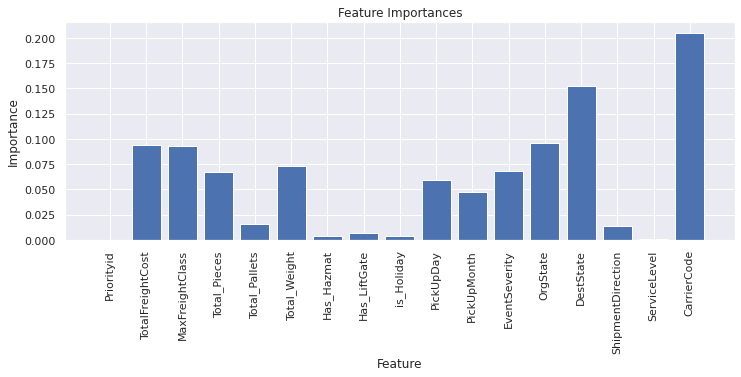

In [21]:
Cols=['Priorityid',
             'TotalFreightCost',
             'MaxFreightClass',
             'Total_Pieces',
             'Total_Pallets',
             'Total_Weight',
             'Has_Hazmat',
             'Has_LiftGate',
             'is_Holiday',
             'PickUpDay',
             'PickUpMonth',
             'EventSeverity',
             'OrgState',
             'DestState',
             'ShipmentDirection',
             'ServiceLevel',
             'CarrierCode']
    
importances = best_model.featureImportances

x_values = list(range(len(importances)))

fig = plt.figure(figsize=(12,4))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, Cols, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')



## Random Forest Análisis de resultados

-Al intentar hacer el entrenamiento con todos los registros, aproximadamente 100 mil registros, nunca convergió, el container retorno errores de out of memory

-Se tomó la decisión  de tomar una muestra de 25 mil registros, el tiempo de entrenamiento tomo alrededor de 1 hora

-Las distintas métricas dan un resultado entre 74 y 75,en este caso, random forest no es un buen predictor
    
-Se nota una alta tasa de falsos positivos, este factor , podría no ser un defecto mayor, ya que el objetivo del modelo es predecir un posible atraso de una carga, para generar una alerta a nivel administrativo.

-Best Model: Muestra que el modelo optimo este dado por 80 arboles
 
-feature importances: De esta propiedad se concluye que ciertas características aportan poca información para el método de entropía de los árboles de decisión, se podrian, se podrían eliminar las variables: Priority, service Leve, isHoliday y Has_Hazmat.

-La severidad de los eventos del tiempo sin duda son elemento muy importante para determinar los atrasos en los sistemas de transporte, en este caso, se nota que esta característica no aporto mucha importancia a la hora de predecir.




# Modelo 1

## SVM

In [53]:

from pyspark.ml.feature import VectorAssembler

db_url="jdbc:postgresql://host.docker.internal:5433/postgres"
# traer datos de posgress
df = spark \
    .read \
    .format("jdbc") \
    .option("url", db_url) \
    .option("user", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .option("password", "testPassword") \
    .option("dbtable", "finaldf") \
    .load()


df = df.withColumn("MaxFreightClass", col("MaxFreightClass").cast("Integer"))
df = df.withColumn("Total_Weight", col("Total_Weight").cast("double"))

df = df.drop("PickupDate")

In [54]:
df=df.sample(withReplacement=False, fraction=0.1)
df.count()

50108

In [55]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

categorical_columns= ['OrgState', 'DestState', 'ShipmentDirection', 'ServiceLevel','CarrierCode']

# The index of string vlaues multiple columns
indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in categorical_columns
]

# The encode of indexed vlaues multiple columns
encoders = [OneHotEncoder(dropLast=False,inputCol=indexer.getOutputCol(),
            outputCol="{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in indexers
]

# Vectorizing encoded values
assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders],outputCol="features")

pipeline = Pipeline(stages=indexers + encoders+[assembler])
model=pipeline.fit(df)
transformed = model.transform(df)
transformed.columns

['OrgState',
 'DestState',
 'ShipmentDirection',
 'ServiceLevel',
 'Priorityid',
 'TotalFreightCost',
 'MaxFreightClass',
 'Total_Pieces',
 'Total_Pallets',
 'Total_Weight',
 'CarrierCode',
 'Has_Hazmat',
 'Has_LiftGate',
 'is_Holiday',
 'PickUpDay',
 'PickUpMonth',
 'EventSeverity',
 'ConRetraso',
 'OrgState_indexed',
 'DestState_indexed',
 'ShipmentDirection_indexed',
 'ServiceLevel_indexed',
 'CarrierCode_indexed',
 'OrgState_indexed_encoded',
 'DestState_indexed_encoded',
 'ShipmentDirection_indexed_encoded',
 'ServiceLevel_indexed_encoded',
 'CarrierCode_indexed_encoded',
 'features']

In [56]:
vector_df = transformed.select(col("features"),col("ConRetraso"))

In [57]:
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import col

standard_scaler = StandardScaler(inputCol='features', outputCol='scaled')
scale_model = standard_scaler.fit(vector_df)

scale_df = scale_model.transform(vector_df)

In [58]:
train_df, test_df = scale_df.randomSplit([0.7, 0.3], seed = 2018)
train_df = train_df.select(col("ConRetraso").alias("label"), col("scaled"))
test_df = test_df.select(col("ConRetraso").alias("label"), col("scaled"))
print("Training Dataset Count: " + str(train_df.count()))
print("Test Dataset Count: " + str(test_df.count()))

Training Dataset Count: 35111
Test Dataset Count: 14997


In [183]:

from pyspark.ml.classification  import LinearSVC
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create an initial RandomForest model.
lsvc  = LinearSVC(labelCol="label", featuresCol="scaled")

# Evaluate model
VM_Evaluator = BinaryClassificationEvaluator()


VMparamGrid = (ParamGridBuilder()
               .addGrid(lsvc.maxIter , [5,10,20,50,100]) #, 10,20,30]
               .addGrid(lsvc.regParam, [0.01,0.1,2,5])#, 20,40,80
               .addGrid(lsvc.aggregationDepth, [2,4,6,20])#, 20,40,80
               
             .build())

# Create 5-fold CrossValidator
VM_crossvalidator = CrossValidator(estimator = lsvc,
                      estimatorParamMaps = VMparamGrid,
                      evaluator = VM_Evaluator,
                      numFolds = 5)

lsvcModel = VM_crossvalidator.fit(train_df)

#get predictions for test dataframe
VMpredictions = lsvcModel.transform(test_df)

VMpredictions = VMpredictions.withColumn('prediction', VMpredictions['prediction'].cast(IntegerType()))

print(lsvcModel)


CrossValidatorModel_6362f5961ba2


In [184]:
best_model = lsvcModel.bestModel 

print(best_model)

LinearSVCModel: uid=LinearSVC_4ebfee51e95c, numClasses=2, numFeatures=189


In [185]:
VM_Evaluator.setMetricName("areaUnderROC").evaluate(VMpredictions)

0.7866660468578333

In [186]:

from pyspark.mllib.evaluation import MulticlassMetrics

dfPredictions = VMpredictions.select(['prediction','label']).orderBy('prediction')

dfPredictions = dfPredictions.withColumn("prediction", col("prediction").cast("Float"))
dfPredictions = dfPredictions.withColumn("label", col("label").cast("Float"))

dfPredictions= dfPredictions.orderBy('prediction')


metrics = MulticlassMetrics(dfPredictions.rdd.map(tuple))

# Confusion Matrix
print(metrics.confusionMatrix())

DenseMatrix([[4906., 2568.],
             [1818., 5664.]])


In [187]:
from  pyspark.ml.evaluation import MulticlassClassificationEvaluator

dfPredictions = dfPredictions.withColumn("prediction", col("prediction").cast("Double"))
dfPredictions = dfPredictions.withColumn("label", col("label").cast("Double"))

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(dfPredictions)
print("Accuracy = %g" % accuracy)
 
evaluatorf1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = evaluatorf1.evaluate(dfPredictions)
print("f1 = %g" % f1)
 
evaluatorwp = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
wp = evaluatorwp.evaluate(dfPredictions)
print("weightedPrecision = %g" % wp)
 
evaluatorwr = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
wr = evaluatorwr.evaluate(dfPredictions)
print("weightedRecall = %g" % wr)

Accuracy = 0.70674
f1 = 0.705993
weightedPrecision = 0.708825
weightedRecall = 0.70674


## Experimento con PCA


Proyección del dataset en 3 dimensiones para visualizar la posibles diferencias entre las dos clases


In [59]:
from pyspark.ml.feature import PCA as PCAml

pca = PCAml(k=3, inputCol="scaled", outputCol="pca")
model = pca.fit(train_df)
transformed = model.transform(train_df)

In [60]:
from pyspark.ml.functions import vector_to_array
ds = transformed.withColumn("xs", vector_to_array("pca"))\
    .select( [col("xs")[i] for i in range(3)] + ["label"] )

In [61]:
ds = ds.distinct().toPandas()

In [62]:
import numpy as np    
idx_1 = np.where(ds.label == 1)
idx_0 = np.where(ds.label == 0)

ds = ds.rename(columns={'xs[0]':'x'})
ds = ds.rename(columns={'xs[1]':'y'})
ds = ds.rename(columns={'xs[2]':'z'})

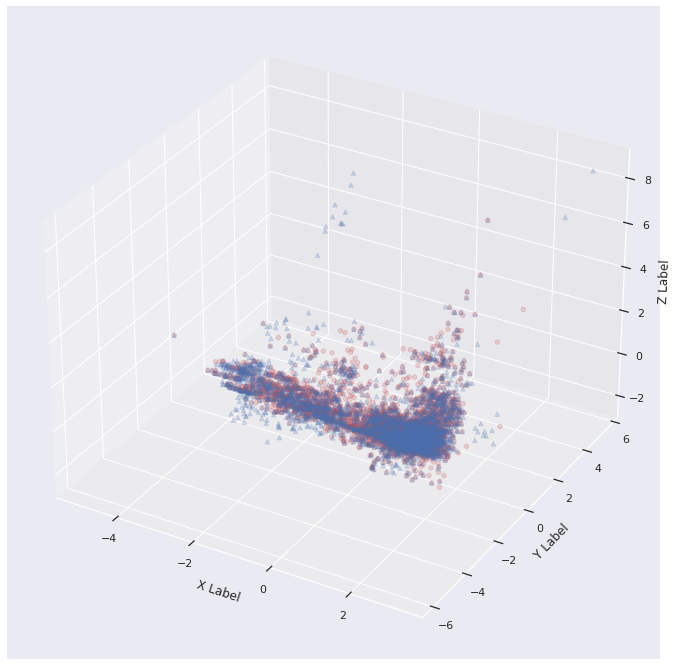

In [68]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(111, projection='3d')

xs =ds.iloc[idx_1].x
ys =ds.iloc[idx_1].y
zs =ds.iloc[idx_1].z

xt =ds.iloc[idx_0].x
yt =ds.iloc[idx_0].y
zt =ds.iloc[idx_0].z

ax.scatter(xs, ys, zs, c='r', marker='o',alpha=0.2)
ax.scatter(xt, yt, zt, c='b', marker='^',alpha=0.2)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


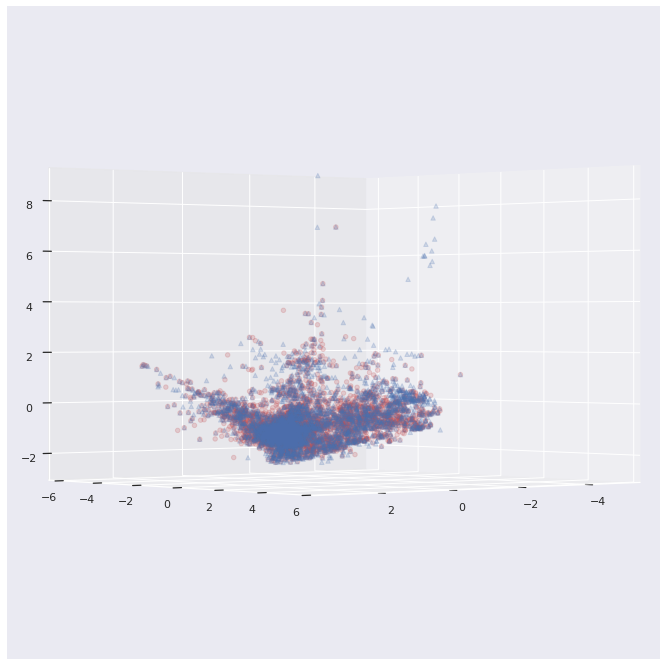

In [77]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs, ys, zs, c='r', marker='o',alpha=0.2)
ax.scatter(xt, yt, zt, c='b', marker='^',alpha=0.2)
ax.view_init(0, 50)
plt.show()

Es probable que PCA pierda información importante, en el caso de reducción en tres dimensiones no se nota una clara división de las dos variables de predicción.

## SVM Análisis de resultados


-Las distintas métricas no dan buenos resultados para SVM, cercano al 70%.

-La versión de SVM de spark no permite el uso de kernels, solamente hace uso de una division lineal de los datos, para este caso, probablemente no existe un hiperplano que divida el dataset.

-El entrenamiento de SVM es mucho más rápido que random forest

-Al proyectar las 17 variables en un plano de 3 dimensiones mediante PCA, se nota que ambas clases (con y sin atraso) están concentradas en mismas regiones, esto hace que sea difícil distinguir una clase de otra.



## Conclusiones Generales

-Random forest logra una leve mejora de métricas con respecto a SVM, sin embargo su tiempo de entrenamiento es mucho mayor

-Ambos modelos están dando una alta tasa de falsos positivos, esto no es tan negativo ya que el caso de uso busca prevenir posibles atrasos para tomar acciones administrativas.

-Las variables disponibles no aportan suficiente información para separar el objetivo predictivo

-EventSeverity se calculó sumando todos los eventos por estado, dando mayor peso a los eventos mas severos, el problema con esta aproximación es que muchos estados son extensiones territoriales muy grandes y probablemente no representan la situación real en que se lleve a cabo el transporte.

-En futuros experimentos se podría tomar los diez zip code de origen y destino con mas volúmenes de cargas, en este caso, no seria necesario sumar los eventos del tiempo ya que el dataset original viene dado a nivel de zip codes.

-Se puede considerar eliminar variables como: priority, service level, has hazmat, is Holiday, ya que estas no aportan mayor información para distinguir las clases y probar  otras características de las cargas.

-Pruebas con distintas cantidades de datos dieron resultados muy parecidos, las columnas seleccionadas son las que no aportando suficiente información para distinguir la variable de predicción.